# A quick tutorial on using Wosis

Before we start, some known issues:

* Methods - especially plotting - switch from relying on Pandas DataFrames to Metaknowledge Collections.
This is because some things are easier to accomplish with one or the other. In the future, I hope to consolidate these to use just one, not a mishmash of both. 

* Some documentation is currently missing

Suggestions on how to improve usability is appreciated, and can be made by [submitting an issue](https://github.com/ConnectedSystems/wosis/issues) with a 'usability' tag.

The cell below shows the Python version in use for this guide. Versions equal to and above should be fine.

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import sys
print(sys.version_info)

sys.version_info(major=3, minor=5, micro=6, releaselevel='final', serial=0)


There are two options to install Wosis for development use:

1) clone the project with `git` (the dollar sign represents the terminal prompt)

```bash
$ git clone https://github.com/ConnectedSystems/wosis.git
$ cd wosis
$ pip install git+https://github.com/ConnectedSystems/metaknowledge.git@add-collections
$ pip install git+https://github.com/titipata/wos_parser.git@master
$ pip install -e .
```

2) download, and extract, the project files from the [github repo](https://github.com/ConnectedSystems/wosis) (look for the green button on the right hand side)

```bash
$ pip install git+https://github.com/ConnectedSystems/metaknowledge.git@add-collections
$ pip install git+https://github.com/titipata/wos_parser.git@master
$ pip install -e .
```

Note the period (`.`) - yes it is important!

The first two `pip install` commands downloads and installs specific package versions that are required by Wosis.

Wosis relies on NLTK for lemmatization and stemming.

This requires the WordNet data to be downloaded and made available

```python
import nltk

# Display list of locations NLTK searches for language data
print(nltk.data.path)

# Example only
# ['C:\\nltk_data',
#  'D:\\nltk_data',
#  'E:\\nltk_data']

# Select a desired location from the above and run the below
# Here, I selected the second item in the list (Python is a zero-indexed language)
download_location = nltk.data.path[1]
nltk.download('wordnet', download_dir=download_location)
```

To start with, lets import the relevant packages

In [3]:
import wosis
import pandas as pd
import metaknowledge as mk

To access the Web of Science API, we need to load a configuration file that specifies your user details.

Remember not to share your account details with anyone, or store it in a publicly accessible repository of any sort.

The `config.yml` file should hold your Web of Science username and password, like so:

```yaml
wos:
  user: username
  password: password
```

Here we assume the `config.yml` file is in the same directory as the notebook

In [4]:
wos_config = wosis.load_config("config.yml")

Now we specify the search terms. This can be specified manually (see the [advanced search examples](https://images.webofknowledge.com/WOKRS533AR16/help/WOS/hp_advanced_examples.html) for more detail) or generated via a dictionary.

Search queries are expected to be a list, so you can submit multiple search queries.

In [5]:
# dollar sign ($) is a wildcard used to match British and American spellings
# e.g. flavo$r matches both flavour and flavor
# see https://images.webofknowledge.com/images/help/WOS/hs_wildcards.html
search_terms = {
    "inclusive_kw": ("Integrated Model$ing", ),  # Keywords to include (NOTE THE TRAILING COMMA FOR SINGLE ENTRIES)
    "exclusive_kw": ("chemical", "industry", "cancer", "gene"), # Keywords to exclude
    "exclusive_jo": ('PSYCHOL*', ),  # Journals to exclude (the * tries to match anything after 'PSYCHOL')
    "subject_area": ("ENVIRONMENTAL SCIENCES", "WATER RESOURCES", "ENGINEERING ENVIRONMENTAL", "INTERDISCIPLINARY APPLICATIONS"),
}

topics = [wosis.build_query(search_terms), ]
topics

['TS=(("Integrated Model$ing") NOT ("chemical" OR "industry" OR "cancer" OR "gene")) NOT SO=("PSYCHOL*") AND WC=("ENVIRONMENTAL SCIENCES" OR "WATER RESOURCES" OR "ENGINEERING ENVIRONMENTAL" OR "INTERDISCIPLINARY APPLICATIONS")']

The above will create the same search query as the below

In [6]:
topics = ['TS=(("Integrated Model$ing") NOT ("chemical" OR "industry" OR "cancer" OR "gene")) NOT SO=("PSYCHOL*") AND WC=("ENVIRONMENTAL SCIENCES" OR "WATER RESOURCES" OR "ENGINEERING ENVIRONMENTAL" OR "INTERDISCIPLINARY APPLICATIONS")']

Now we send off the query.

Strangely, the time span of interest is not accepted as part of the WoS query, but we can specify this separately.

The `%%time` Jupyter magic command is there so we know how long this process took.

For very large amounts of records, getting the data can take a long time.

Sometimes the retrieval process fails - this could be due to high amounts of traffic to the WoS servers. Most times there's no other option other than to try again.

In [7]:
%%time

# This variable ensures that we do not overwrite previous identical search if it exists
# We usually want to keep a cached copy for later analysis because requests can take a long time to process
# Be sure to delete the cached file when no longer needed!
overwrite = False

id_to_query, query_recs = wosis.query(topics, 
                                      overwrite,
                                      wos_config, 
                                      time_span={'begin': '2014-01-01', 'end': '2017-12-31'},
                                      skip_refs=False)

Wall time: 43 ms


Note that if `skip_refs` is `True`, Wosis then does not request any data on citations within the corpora.
Because it skips collecting the reference list data for each publication in the corpora we cannot subsequently do any analysis on cited works.

The query function will return two dictionaries:

* a unique ID for each query sent, and 
* the query result, with the IDs as the keys

The IDs are useful in case you need to find the cache file later on.

In [8]:
id_to_query

{'72e7af00b238db01d2b12d9a3c6a4fb6_2014-01-01-2017-12-31': 'TS=(("Integrated Model$ing") NOT ("chemical" OR "industry" OR "cancer" OR "gene")) NOT SO=("PSYCHOL*") AND WC=("ENVIRONMENTAL SCIENCES" OR "WATER RESOURCES" OR "ENGINEERING ENVIRONMENTAL" OR "INTERDISCIPLINARY APPLICATIONS")'}

In [9]:
query_recs

{'72e7af00b238db01d2b12d9a3c6a4fb6_2014-01-01-2017-12-31': <metaknowledge.RecordCollection object 72e7af00b238db01d2b12d9a3c6a4fb6_2014-01-01-2017-12-31_ris>}

For those of you new to Python/Jupyter Notebooks, more information on the functions used here can be seen using `?` 

In [10]:
?wosis.query

We can get the publication records from the query result set directly. Remember, we only sent one query so it will be the first item in the dictionary

In [11]:
RC = list(query_recs.values())[0]

print("Corpora consists of", len(RC), "Publications")

Corpora consists of 276 Publications


As explained above, `query_recs` is a dictionary that maps a result ID to the matching publication set.

The `wosis.query()` function will write out the query_id information in a text file so you know which dataset is associated with which query. The default location is a directory called `tmp`. Read the documentation for the `wosis.query()` function for more information.

In this example, the unique ID for the query we just sent is `72e7af00b238db01d2b12d9a3c6a4fb6` (as you can see in the above cell).

The resulting data is cached in RIS format.

Wosis, through Metaknowledge, can read such RIS formatted data, for example exported from a reference manager such as EndNote, Mendeley, or Zotero (and others). 

In this example the dataset is cached in a `txt` file labelled with the `query_id`.

The associated dataset can then be read back in like so:

```python
RC = wosis.load_query_results('72e7af00b238db01d2b12d9a3c6a4fb6', file_loc='tmp')
```

Otherwise, we can get the publication records from the query result set directly, as we did above

```python

# Get the ID of the query result set:
query_id = list(id_to_query)[0]

print("Query ID: ", query_id, "\nQuery String:", id_to_query[query_id], "\n")

# Load it in as a metaknowledge collection
RC = mk.RecordCollection("tmp/{}.txt".format(query_id))

# If we want to constrain the time frame later, this is how we do it
# RC = RC.yearSplit(0, 2017)
```

Before we do any analysis, let's write out a representative dataset.

To use it for publication (e.g. adding it to an appendix or making it available for transparency purposes) the dataset has to be stripped of the WoS generated keywords, abstract, and some other ancillary data as these are proprietary owned by Clarivate.

At the time of writing, the usage agreement states that any dataset derived from Web of Science made publicly available has to specify that it came from Clarivate, and when the data was retrieved. This has to be included inside any file you share.

Wosis can do this for you, as shown in the cell below.

First create a `data` directory in the location indicated (`..` means "the level above the current directory" which should be where this notebook is)

Don't forget to change the retrieval date!

```python
wosis.export_representative_file(RC, retrieval_date='1 December 2018', data_fn='../data/repset.csv')
```

In this tutorial, I will be hiding the columns specified below - these hold data which Clarivate Analytics prefers us not to share.

In [12]:
# Hiding keywords and abstract for tutorial (WoS-owned IP)
hide_columns = ['DE', 'abstract', 'keywords', 'DOI', 'id', 'kws']

Now the fun begins.

Analysis setup:

In [13]:
# Helper functions for plotting
import wosis.analysis.plotting as wos_plot

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# This just helps make the plots look nicer
sns.set_style('darkgrid')
sns.set_context('paper', font_scale=2.0)

Basic analysis can be done with Pandas, but more complicated stuff is made simple with the included Wosis helper functions

For the purposes of this tutorial, lets assume that publications without DOIs are unusable for our analysis.

The cell below will convert the records to a Pandas DataFrame, and then remove rows with blank DOIs.

In [14]:
corpora_df = wosis.rc_to_df(RC)
corpora_df, removed_pubs = wosis.remove_empty_DOIs(corpora_df)

Removing 18 records with no DOIs


We can also filter by partial match on Journal name and titles.

These methods will print out the number of articles removed for each search string.

*WARNING:* This example uses Pandas DataFrames. Future versions of Wosis will apply the changes to a Metaknowledge collection instead

In [15]:
# Hypothetical list of unrelated Journals - will be matched by partial string
unrelated_jo = ['Total Environ']

# Think of the parameter order like "with this dataset, remove these unrelated journals"
corpora_df = wosis.remove_by_journals(corpora_df, unrelated_jo)

Total Environ: 8


In [16]:
# Hypothetical list of known unrelated titles (again, by partial match)
unrelated_TI = ['agriculture']

# Again, with this dataset remove these titles
corpora_df = wosis.remove_by_title(corpora_df, unrelated_TI)

agriculture: 1


We can then create a new Metaknowledge collection using the WOS ID

In [17]:
filtered_corpora = wosis.extract_recs(corpora_df.id, RC, name='Filtered Corpora')

Wosis has a number of convenient plotting functions. 

All of plotting functions 
* can save the resulting figure to a file by giving a file location to the `save_plot_fn` parameter.
  The figure will be saved in PNG format at 300dpi.
* returns a matplotlib figure object so you can make further adjustments if desired

For example:

```python
wos_plot.plot_pub_trend(filtered_corpora, title='Publication Trend', save_plot_fn=r'C:\temp\my_figure.png')
```

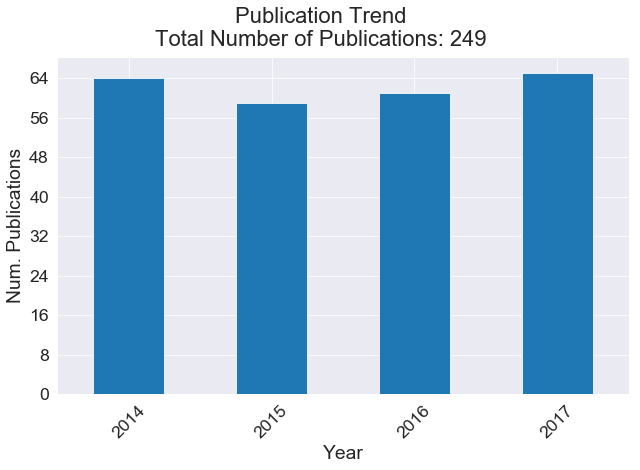

In [18]:
# Plotting out the publication trend. 
wos_plot.plot_pub_trend(filtered_corpora, title='Publication Trend', save_plot_fn=False)

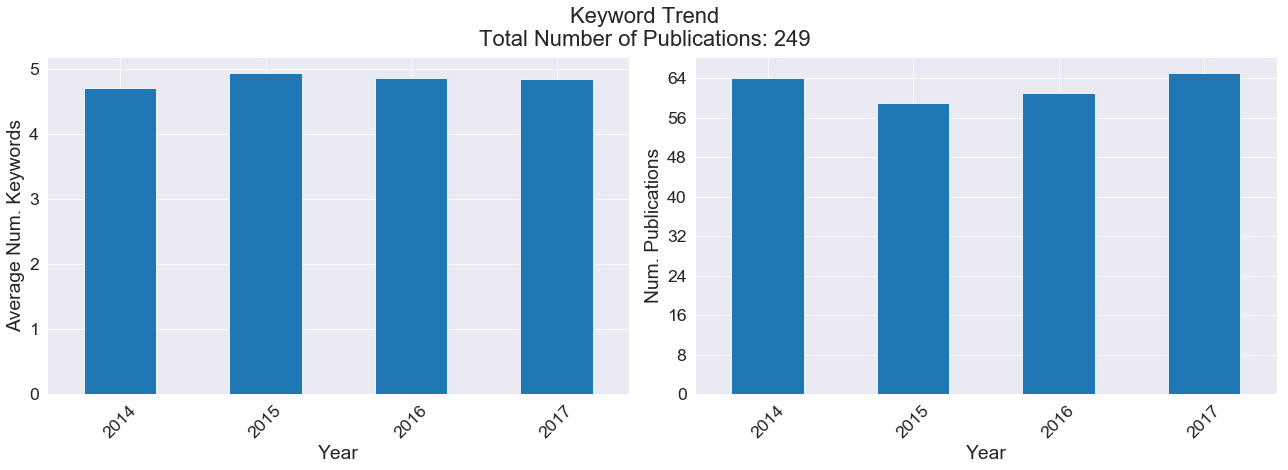

In [19]:
# Plot out the keyword trend
wos_plot.plot_kw_trend(filtered_corpora, title='Keyword Trend', save_plot_fn=False)

You can also sort the publications into specific criterias.

This matches similar words as found in the title, abstract, and keyword sections.

In [20]:
# Keyword types adapted from Zare et al. (2017)
# http://dx.doi.org/10.1016/j.jhydrol.2017.07.031

criteria = {
    'overarching': set(['uncertainty', 'adapt', 'decision support', 'management', 'gis']),
    'agri': set(['agricultur', 'farm']),
    'water': set(['hydrology', 'water', 'stream', 'aquifer']),
    'enviro': set(['environment', 'climate', 'ecology', 'ecosystem', 'biodivers']),
    'socio_economic': set(['ecosystem service', 'social', 'conflict', 'particip', 'law', 'stakehold', 'policy', 'economic'])
}

criteria_matches = wosis.keyword_matches_by_criteria(filtered_corpora, criteria, threshold=95.0)

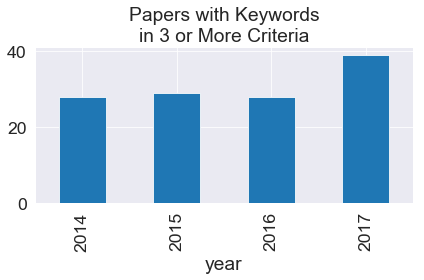

In [21]:
criteria_df = wosis.collate_keyword_criteria_matches(filtered_corpora, criteria_matches)
wos_plot.plot_criteria_trend(criteria_df, threshold=3)

Remember, you can look at the documentation for anything with the question mark magic command

In [22]:
?wos_plot.plot_criteria_trend

If desired, you can search the publications for a specific keyword (or list of keywords).

Here, we look for some keywords related to the field costs - anything that is 95% similar to the given keywords is acceptable.

In [23]:
matching_records = wosis.keyword_matches(filtered_corpora, ['finance', 'costs', 'capita', 'monetary'], threshold=95.0)

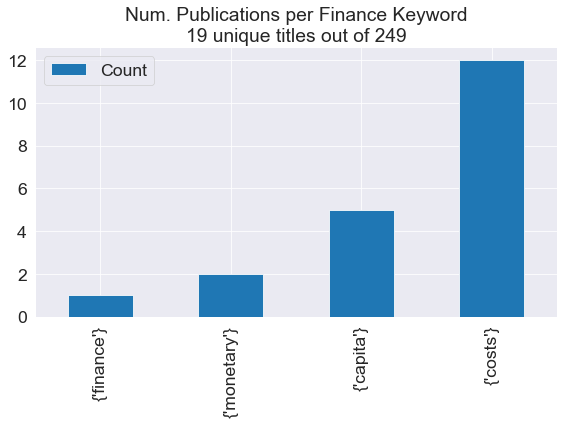

In [24]:
wos_plot.plot_pub_per_kw(matching_records, filtered_corpora, kw_category='Finance')

We can then attempt to find topics of interest

In [25]:
topic_results = wosis.find_topics(filtered_corpora, num_topics=10)

Topic 1: model use integr data environment develop framework approach river process
Topic 2: water irrig river demand manag suppli basin resourc agricultur management
Topic 3: urban water infrastructur modelling plan integr drainage model new infrastructure
Topic 4: climat chang change climate futur impact crop scenario agricultur region
Topic 5: flood flash catchment rainfal hazard region river lake runoff occurr
Topic 6: plant cement emiss calcin sourc carbon emissions power calpuff concentr
Topic 7: groundwat flow groundwater surface surfac water recharg storag aquif subsurfac
Topic 8: land use soil chang scenario eros sediment change cov farm
Topic 9: energy energi transport carbon modeling generation integrated electr build effici
Topic 10: air traffic pollut european road modelling pollution qualiti approach emiss


If the identified topics are too vague or not of interest, try increasing the number of topics. Conversely, if they are too specific, try lowering the number of topics.

Say we're interested in Topic 2. The cell below shows how to get the publications for this topic.

In [26]:
id_of_interesting_topic = 2
topic_set = topic_results.get_topic_by_id(id_of_interesting_topic)

In [27]:
print("Number of publications in topic set:", len(topic_set))

Number of publications in topic set: 20


In [28]:
# The publication set of interest!
# Hiding keywords and abstract for tutorial (WoS-owned IP)
topic_set.loc[:, ~topic_set.columns.isin(hide_columns)].head(10)  # show first 10

,AU,SO,copyright,title,year
2,"Dai, Shanshan|Li, Lanhai|Xu, Honggang",WATER POLICY,,Simulation of water scarcity in a leap-forward...,2017
14,"Momblanch, Andrea|Paredes-Arquiola, Javier|And...",ENVIRONMENTAL MODELLING & SOFTWARE,Elsevier Ltd. All rights reserved.,Improved modelling of the freshwater provision...,2017
26,"Loeffler, Michael|Brinkop, Sabine|Joeckel, Pat...",ATMOSPHERIC CHEMISTRY AND PHYSICS,,Impact of major volcanic eruptions on stratosp...,2016
27,"Li, Na|Wang, Xiaojun|Shi, Minjun|Yang, Hong",SUSTAINABILITY,,Economic Impacts of Total Water Use Control in...,2015
40,"Hao, Lu|Sun, Ge|Liu, Yongqiang|Qian, Hong",JOURNAL OF THE AMERICAN WATER RESOURCES ASSOCI...,,Integrated Modeling of Water Supply and Demand...,2015
54,"McNeill, Kelsie|Macdonald, Kiera|Singh, Ashuto...",AGRICULTURAL WATER MANAGEMENT,(C) 2017 Elsevier B.V. All rights reserved.,Food and water security: Analysis of integrate...,2017
73,"Schuetze, Niels|Stange, Peter|Griessbach, Ulri...",HYDROLOGIE UND WASSERBEWIRTSCHAFTUNG,,Integrated modelling and optimisation of irrig...,2016
76,"Lai, Y. C.|Chien, C. C.|Yang, Z. H.|Surampalli...",WATER ENVIRONMENT RESEARCH,,Developing an Integrated Modeling Tool for Riv...,2017
81,"Veettil, Anoop Valiya|Mishra, Ashok K.",JOURNAL OF HYDROLOGY,(C) 2016 Elsevier B.V. All rights reserved.,Water security assessment using blue and green...,2016
88,"Milano, Marianne|Reynard, Emmanuel|Bosshard, N...",HOUILLE BLANCHE-REVUE INTERNATIONALE DE L EAU,,In light of seasonal climatic and anthropogeni...,2016


Lets extract the records of interest from the original record collection and do some analysis

In [29]:
topic_recs = wosis.extract_recs(topic_set.id, RC, 'Topic of Interest')

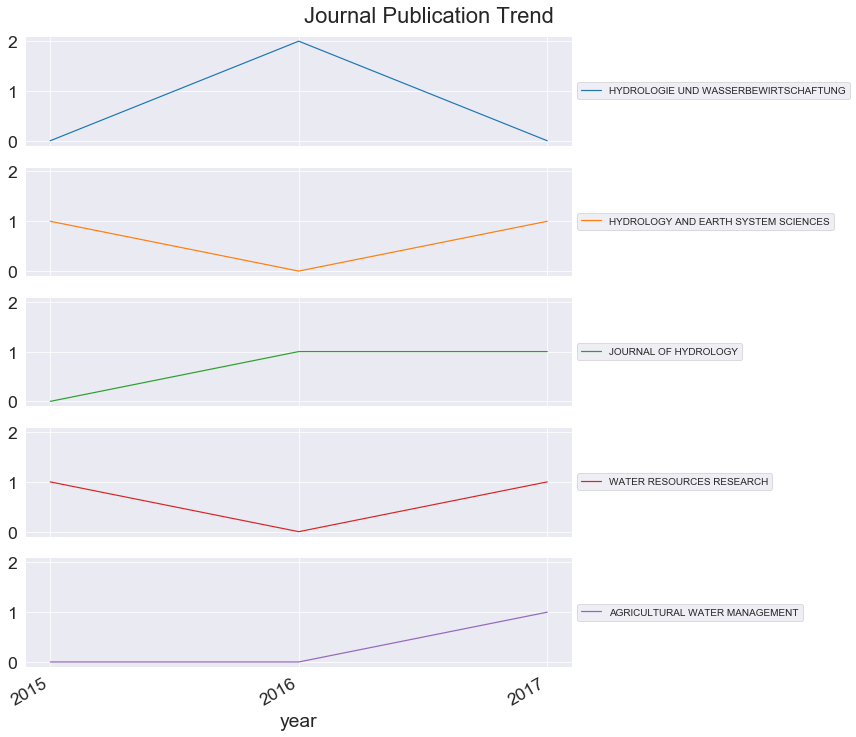

In [30]:
# The publication trend per journal (showing trends for top 5)
wos_plot.plot_journal_pub_trend(topic_recs, top_n=5)

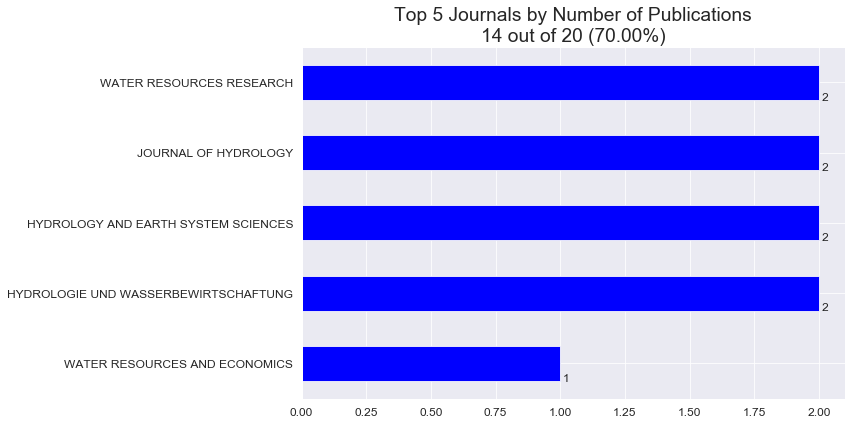

In [31]:
# The overall number of publications for each journal
wos_plot.plot_pubs_per_journal(topic_recs, top_n=5, annotate=True, show_stats=True)

Identify which publications were cited by the corpora

To be explicitly clear: This does NOT identify which the paper in the collection with the most citations
It identifies the papers that the corpora cites the most.

In [32]:
wosis.analysis.pub_citations(topic_recs)[0:5]

,Citations
Publication,
"Wada, Yoshihide, 2013, Multimodel projections and uncertainties of irrigation water demand under climate change, GEOPHYSICAL RESEARCH LETTERS, 40, 4626, 459802479",9
"Nazemi, A., 2015, On inclusion of water resource management in Earth system models - Part 1: Problem definition and representation of water demand, HYDROLOGY AND EARTH SYSTEM SCIENCES, 19, 33, 482280867",6
"Doell, P., 2012, Impact of water withdrawals from groundwater and surface water on continental water storage variations, JOURNAL OF GEODYNAMICS, 59-60, 143, 437156432",6
"Hanasaki, N., 2008, An integrated model for the assessment of global water resources Part 1: Model description and input meteorological forcing, HYDROLOGY AND EARTH SYSTEM SCIENCES, 12, 1007, 92987622",6
"Vorosmarty, CJ, 2000, Global water resources: Vulnerability from climate change and population growth, SCIENCE, 289, 284, 9712516",6


To get citations for each paper in the collection we have to request these from WoS.

If there are a large number of publications it may take a long time. Wosis will attempt to recover from any errors for you, but it does depend on how busy the WoS servers are.

In [33]:
?wosis.get_citing_works()

In [34]:
topic_cites = wosis.get_num_citations(topic_recs, wos_config)

Authenticated (SID: 5BegLp2EB9m8OWNsjzM)


In [35]:
topic_cites[['AU', 'title', 'citations']].head()

,AU,title,citations
0,"Nazemi, A.|Wheater, H. S.",On inclusion of water resource management in E...,48
1,"Wu, Bin|Zheng, Yi|Wu, Xin|Tian, Yong|Han, Feng...",Optimizing water resources management in large...,32
2,"Veettil, Anoop Valiya|Mishra, Ashok K.",Water security assessment using blue and green...,25
3,"Li, Na|Wang, Xiaojun|Shi, Minjun|Yang, Hong",Economic Impacts of Total Water Use Control in...,17
4,"Voisin, Nathalie|Hejazi, Mohamad I.|Leung, L. ...",Effects of spatially distributed sectoral wate...,10


Authors in the corpora with the most citations (careful interpreting this author names are grouped by surname so it is misleading)

In [36]:
wosis.author_citations(topic_recs)[0:10]

,Citations
Publication,
Liu,15
Nazemi,11
Li,11
Wada,11
Hanasaki,9
Allen,8
Haddeland,7
Doell,7
Richter,7


Publications that cite a specific paper can also be identified

Using the `wosis.get_citing_works()` function - use the `?` command for more information.

Wosis can also help create links to the publications where possible

In [37]:
topic_df = wosis.link_to_pub(topic_recs)  # Creates a new column called 'DOI link'
topic_df.loc[:, ~topic_df.columns.isin(hide_columns)].head(10)

,AU,SO,title,year,DOI link
0,"Lai, Y. C.|Chien, C. C.|Yang, Z. H.|Surampalli...",WATER ENVIRONMENT RESEARCH,Developing an Integrated Modeling Tool for Riv...,2017,https://dx.doi.org/10.2175/106143016X147983533...
1,"Wu, Bin|Zheng, Yi|Wu, Xin|Tian, Yong|Han, Feng...",WATER RESOURCES RESEARCH,Optimizing water resources management in large...,2015,https://dx.doi.org/10.1002/2014WR016653
2,"Dai, Shanshan|Li, Lanhai|Xu, Honggang",WATER POLICY,Simulation of water scarcity in a leap-forward...,2017,https://dx.doi.org/10.2166/wp.2017.132
3,"Winter, Jonathan M.|Lopez, Jose R.|Ruane, Alex...",ANTHROPOCENE,Representing water scarcity in future agricult...,2017,https://dx.doi.org/10.1016/j.ancene.2017.05.002
4,"Talati, Shuchi|Zhai, Haibo|Kyle, G. Page|Morga...",ENVIRONMENTAL SCIENCE & TECHNOLOGY,Consumptive Water Use from Electricity Generat...,2016,https://dx.doi.org/10.1021/acs.est.6b01389
5,"Veettil, Anoop Valiya|Mishra, Ashok K.",JOURNAL OF HYDROLOGY,Water security assessment using blue and green...,2016,https://dx.doi.org/10.1016/j.jhydrol.2016.09.032
6,"Gibbs, M. S.|Dandy, G. C.|Maier, H. R.",STOCHASTIC ENVIRONMENTAL RESEARCH AND RISK ASS...,Assessment of the ability to meet environmenta...,2014,https://dx.doi.org/10.1007/s00477-013-0735-9
7,"Han, Bangshuai|Benner, Shawn G.|Bolte, John P....",HYDROLOGY AND EARTH SYSTEM SCIENCES,Coupling biophysical processes and water right...,2017,https://dx.doi.org/10.5194/hess-21-3671-2017
8,"Loeffler, Michael|Brinkop, Sabine|Joeckel, Pat...",ATMOSPHERIC CHEMISTRY AND PHYSICS,Impact of major volcanic eruptions on stratosp...,2016,https://dx.doi.org/10.5194/acp-16-6547-2016
9,"Lobanova, Anastasia|Liersch, Stefan|Tabara, J....",JOURNAL OF HYDROLOGY,Harmonizing human-hydrological system under cl...,2017,https://dx.doi.org/10.1016/j.jhydrol.2017.03.015


Other analysis can easily be accomplished with Pandas